In [13]:
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import torch.nn.functional as F
import gym
import time
import matplotlib.pyplot as plt
from baselines_wrappers import DummyVecEnv, Monitor
from pytorch_wrappers import make_atari_deepmind, BatchedPytorchFrameStack, PytorchLazyFrames
import copy
startTime = time.time()

In [14]:
%%capture
# init Environment
# %pip install -U gym>=0.26.0
# %pip install -U gym[atari,accept-rom-license]

make_env = lambda: Monitor(make_atari_deepmind("ALE/Breakout-v5", scale_values=True), allow_early_resets=True)
vector_env = DummyVecEnv([make_env for _ in range(1)])
env = BatchedPytorchFrameStack(vector_env, k=1)
# env = gym.make('ALE/Breakout-v5')
env.action_space.n = 4
action_space = env.action_space.n
state_space = env.observation_space.shape[0]
max_reward = 90

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

horizon_scale = 0.02
return_scale = 0.02
replay_size = 700
n_warm_up_episodes = 50
n_updates_per_iter = 100
n_episodes_per_iter = 15
last_few = 50
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 256
batch_size = 3

## Behavior Function

In [15]:
def compute_shape(net, env):
    with torch.no_grad():
        n_shape = net(torch.as_tensor(env.observation_space.sample()[None]).float()).shape[1]

    return n_shape

class BF(nn.Module):
    def __init__(self, state_space, action_space):
        super(BF, self).__init__()
        self.actions = np.arange(action_space)
        self.action_space = action_space

        depths = (32, 64, 64)
        final_layer = 512

        self.fc1 = nn.Conv2d(state_space, depths[0], kernel_size=8, stride=4)
        self.commands = nn.Linear(2, depths[0])
        # self.fc2 = nn.ReLU()  # test
        self.fc3 = nn.Conv2d(depths[0], depths[1], kernel_size=4, stride=2)
        self.fc4 = nn.ReLU()
        self.fc5 = nn.Conv2d(depths[1], depths[2], kernel_size=3, stride=1)
        self.fc6 = nn.ReLU()
        self.fc7 = nn.Flatten()
        shape = compute_shape(nn.Sequential(self.fc1, self.fc3, self.fc4, self.fc5, self.fc6, self.fc7), env)
        # shape = compute_shape(nn.Sequential(self.fc1, self.fc2, self.fc3, self.fc4, self.fc5, self.fc6, self.fc7), env)
        self.fc8 = nn.Linear(shape, final_layer)
        self.fc9 = nn.ReLU()
        self.fc10 = nn.Linear(final_layer, action_space)
        self.sigmoid = nn.Sigmoid()

    def forward(self, state, command):
        # Original Forward function
        # out = self.sigmoid(self.fc1(state))
        # command_out = self.sigmoid(self.commands(command))
        # out = out * command_out
        # out = torch.relu(self.fc2(out))
        # out = torch.relu(self.fc3(out))
        # out = torch.relu(self.fc4(out))
        # out = self.fc5(out)

        out = self.sigmoid(self.fc1(state))
        command_out = self.sigmoid(self.commands(command))
        # print("state", out.shape)
        # print("comma", command_out.shape)
        out = out*command_out[:, :, None, None]
        #out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        out = self.fc5(out)
        out = self.fc6(out)
        out = self.fc7(out)
        out = self.fc8(out)
        out = self.fc9(out)
        out = self.fc10(out)

        return out
    
    def action(self, state, desire, horizon):
        """
        Samples the action based on their probability
        """
        command = torch.cat((desire*return_scale,horizon*horizon_scale), dim=-1)
        action_prob = self.forward(state, command)
        probs = torch.softmax(action_prob, dim=-1)
        m = Categorical(probs)
        action = m.sample()
        return action
    def greedy_action(self, state, desire, horizon):
        """
        Returns the greedy action 
        """
        command = torch.cat((desire*return_scale,horizon*horizon_scale), dim=-1)
        action_prob = self.forward(state, command)
        probs = torch.softmax(action_prob, dim=-1)
        action = torch.argmax(probs).item()
        return action

## Replay Buffer

In [16]:
class ReplayBuffer():
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = []
        
        
    def add_sample(self, states, actions, rewards):
        episode = {"states": states, "actions":actions, "rewards": rewards, "summed_rewards":sum(rewards)}
        self.buffer.append(episode)
        
    
    def sort(self):
        #sort buffer
        self.buffer = sorted(self.buffer, key = lambda i: i["summed_rewards"],reverse=True)
        # keep the max buffer size
        self.buffer = self.buffer[:self.max_size]
    
    def get_random_samples(self, batch_size):
        self.sort()
        idxs = np.random.randint(0, len(self.buffer), batch_size)
        batch = [self.buffer[idx] for idx in idxs]
        return batch
    
    def get_nbest(self, n):
        self.sort()
        return self.buffer[:n]
    
    def __len__(self):
        return len(self.buffer)

### init replay buffer with n-warmup runs 

In [17]:

buffer = ReplayBuffer(replay_size)
bf = BF(state_space, action_space).to(device)
optimizer = optim.Adam(params=bf.parameters(), lr=1e-3)

samples = []
#initial command
init_desired_reward = 1 
init_time_horizon = 1 

for i in range(n_warm_up_episodes):
    desired_return = torch.FloatTensor([init_desired_reward])
    desired_time_horizon = torch.FloatTensor([init_time_horizon])
    state = env.reset()
    state = np.stack([obs.get_frames() for obs in state])
    states = []
    actions = []
    rewards = []
    while True:
        action = bf.action(torch.from_numpy(state).float().to(device), torch.unsqueeze(desired_return, 0).to(device), torch.unsqueeze(desired_time_horizon, 0).to(device))
        next_state, reward, done, _ = env.step(action.cpu().numpy())
        next_state = np.stack([obs.get_frames() for obs in next_state])
        reward = int(reward)
        done = bool(done)
        states.append(torch.from_numpy(state).float())
        actions.append(action)
        rewards.append(reward)
        
        state = next_state
        desired_return -= reward
        desired_time_horizon -= 1
        desired_time_horizon = torch.FloatTensor([np.maximum(desired_time_horizon, 1).item()])

        if done:
            break 
        
    # if isinstance(actions[0], torch.Tensor):
    #     for i in range(len(actions)):
    #         actions[i] = actions[i].item()
    buffer.add_sample(states, actions, rewards)


In [18]:
## OBSERVE THE WEIGHTS before training
#for p in bf.parameters():
#    print(p)

In [19]:
# FUNCTIONS FOR Sampling exploration commands

def sampling_exploration( top_X_eps = last_few):
    """
    This function calculates the new desired reward and new desired horizon based on the replay buffer.
    New desired horizon is calculted by the mean length of the best last X episodes. 
    New desired reward is sampled from a uniform distribution given the mean and the std calculated from the last best X performances.
    where X is the hyperparameter last_few.
    
    """
    
    top_X = buffer.get_nbest(last_few)
    #The exploratory desired horizon dh0 is set to the mean of the lengths of the selected episodes
    new_desired_horizon = np.mean([len(i["states"]) for i in top_X])
    # save all top_X cumulative returns in a list
    returns = [i["summed_rewards"] for i in top_X]
    # from these returns calc the mean and std
    mean_returns = np.mean(returns)
    std_returns = np.std(returns)
    # sample desired reward from a uniform distribution given the mean and the std
    new_desired_reward = np.random.uniform(mean_returns, mean_returns+std_returns)

    return torch.FloatTensor([new_desired_reward])  , torch.FloatTensor([new_desired_horizon]) 

In [20]:
# FUNCTIONS FOR TRAINING
def select_time_steps(saved_episode):
    """
    Given a saved episode from the replay buffer this function samples random time steps (t1 and t2) in that episode:
    T = max time horizon in that episode
    Returns t1, t2 and T 
    """
    # Select times in the episode:
    T = len(saved_episode["states"]) # episode max horizon 
    t1 = np.random.randint(0,T-1)
    t2 = np.random.randint(t1+1,T)

    return t1, t2, T

def create_training_input(episode, t1, t2):
    """
    Based on the selected episode and the given time steps this function returns 4 values:
    1. state at t1
    2. the desired reward: sum over all rewards from t1 to t2
    3. the time horizont: t2 -t1
    
    4. the target action taken at t1
    
    buffer episodes are build like [cumulative episode reward, states, actions, rewards]
    """
    state = episode["states"][t1] 
    desired_reward = sum(episode["rewards"][t1:t2])
    time_horizont = t2-t1
    action = episode["actions"][t1]
    return state, desired_reward, time_horizont, action

def create_training_examples(batch_size):
    """
    Creates a data set of training examples that can be used to create a data loader for training.
    ============================================================
    1. for the given batch_size episode idx are randomly selected
    2. based on these episodes t1 and t2 are samples for each selected episode 
    3. for the selected episode and sampled t1 and t2 trainings values are gathered
    ______________________________________________________________
    Output are two numpy arrays in the length of batch size:
    Input Array for the Behavior function - consisting of (state, desired_reward, time_horizon)
    Output Array with the taken actions 
    """
    state_array = []
    desired_reward_array = []
    time_horizon_array = []
    output_array = []
    # select randomly episodes from the buffer
    episodes = buffer.get_random_samples(batch_size)
    for ep in episodes:
        #select time stamps
        t1, t2, T = select_time_steps(ep)
        # For episodic tasks they set t2 to T:
        t2 = T
        state, desired_reward, time_horizont, action = create_training_input(ep, t1, t2)
        state_array.append(state)
        desired_reward_array.append(torch.FloatTensor([desired_reward]))
        time_horizon_array.append(torch.FloatTensor([time_horizont]))
        output_array.append(action)
    return state_array, desired_reward_array, time_horizon_array, output_array

def train_behavior_function(batch_size):
    """
    Trains the BF with on a cross entropy loss were the inputs are the action probabilities based on the state and command.
    The targets are the actions appropriate to the states from the replay buffer.
    """
    X1, X2, X3, y = create_training_examples(batch_size)

    X1 = torch.cat(X1)
    X2 = torch.stack(X2)
    X3 = torch.stack(X3)
    state = X1[:,0:state_space]
    d = X2
    h = X3
    command = torch.cat((d*return_scale,h*horizon_scale), dim=-1)
    y = torch.stack(y).long()
    y_ = bf(state.to(device), command.to(device)).float()
    optimizer.zero_grad()
    y = torch.squeeze(y, 1)
    pred_loss = F.cross_entropy(y_, y)
    pred_loss.backward()
    optimizer.step()
    return pred_loss.detach().cpu().numpy()

In [21]:
def evaluate(desired_return = torch.FloatTensor([init_desired_reward]), desired_time_horizon = torch.FloatTensor([init_time_horizon])):
    """
    Runs one episode of the environment to evaluate the bf.
    """
    state = env.reset()
    rewards = 0
    while True:
        state = np.stack([obs.get_frames() for obs in state])
        state = torch.FloatTensor(state)
        action = bf.action(state.to(device), torch.unsqueeze(desired_return, 0).to(device), torch.unsqueeze(desired_time_horizon, 0).to(device))
        state, reward, done, _ = env.step(action.cpu().numpy()) 
        rewards += reward
        desired_return = min(desired_return - reward, torch.FloatTensor([max_reward]))
        desired_time_horizon = max(desired_time_horizon - 1, torch.FloatTensor([1]))
        
        if done:
            break 
    return int(rewards)
    

## Training Loop

In [22]:
# Algorithm 2 - Generates an Episode unsing the Behavior Function:
def generate_episode(desired_return = torch.FloatTensor([init_desired_reward]), desired_time_horizon = torch.FloatTensor([init_time_horizon])):    
    """
    Generates more samples for the replay buffer.
    """
    state = env.reset()
    states = []
    actions = []
    rewards = []
    while True:
        state = np.stack([obs.get_frames() for obs in state])
        state = torch.FloatTensor(state)

        action = bf.action(state.to(device), desired_return.to(device), desired_time_horizon.to(device))
        next_state, reward, done, _ = env.step(action.cpu().numpy())
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        
        state = next_state
        desired_return -= reward
        desired_time_horizon -= 1
        desired_time_horizon = torch.unsqueeze(torch.FloatTensor([np.maximum(desired_time_horizon, 1).item()]),0)

        if done:
            break 
    return [states, actions, rewards]


# Algorithm 1 - Upside - Down Reinforcement Learning 
def run_upside_down(max_episodes):
    """
    
    """
    all_rewards = []
    losses = []
    average_100_reward = []
    desired_rewards_history = []
    horizon_history = []
    for ep in range(1, max_episodes+1):

        # improve|optimize bf based on replay buffer
        loss_buffer = []
        for i in range(n_updates_per_iter):
            bf_loss = train_behavior_function(batch_size)
            loss_buffer.append(bf_loss)
        bf_loss = np.mean(loss_buffer)
        losses.append(bf_loss)
        
        # run x new episode and add to buffer
        for i in range(n_episodes_per_iter):
            
            # Sample exploratory commands based on buffer
            new_desired_reward, new_desired_horizon = sampling_exploration()
            generated_episode = generate_episode(torch.unsqueeze(new_desired_reward,0), torch.unsqueeze(new_desired_horizon,0))
            # if isinstance(generated_episode[1][0], torch.Tensor):
            #     for i in range(len(generated_episode[1])):
            #         generated_episode[1][i] = generated_episode[1][i].item()
            if isinstance(generated_episode[2][0], np.ndarray):
                for i in range(len(generated_episode[2])):
                    generated_episode[2][i] = generated_episode[2][i][0]
            buffer.add_sample(generated_episode[0],generated_episode[1],generated_episode[2])

        new_desired_reward, new_desired_horizon = sampling_exploration()
        # monitoring desired reward and desired horizon
        desired_rewards_history.append(new_desired_reward.item())
        horizon_history.append(new_desired_horizon.item())
        
        ep_rewards = evaluate(new_desired_reward, new_desired_horizon)
        all_rewards.append(ep_rewards)
        average_100_reward.append(np.mean(all_rewards[-100:]))
        

        print("\rEpisode: {} | Rewards: {:.2f} | Mean_100_Rewards: {:.2f} | Loss: {:.2f}".format(ep, ep_rewards, np.mean(all_rewards[-100:]), bf_loss), end="", flush=True)
        if ep % 100 == 0:
            print("\rEpisode: {} | Rewards: {:.2f} | Mean_100_Rewards: {:.2f} | Loss: {:.2f}".format(ep, ep_rewards, np.mean(all_rewards[-100:]), bf_loss))
            
    return all_rewards, average_100_reward, desired_rewards_history, horizon_history, losses

Episode: 10 | Rewards: 0.00 | Mean_100_Rewards: 0.10 | Loss: 1.38

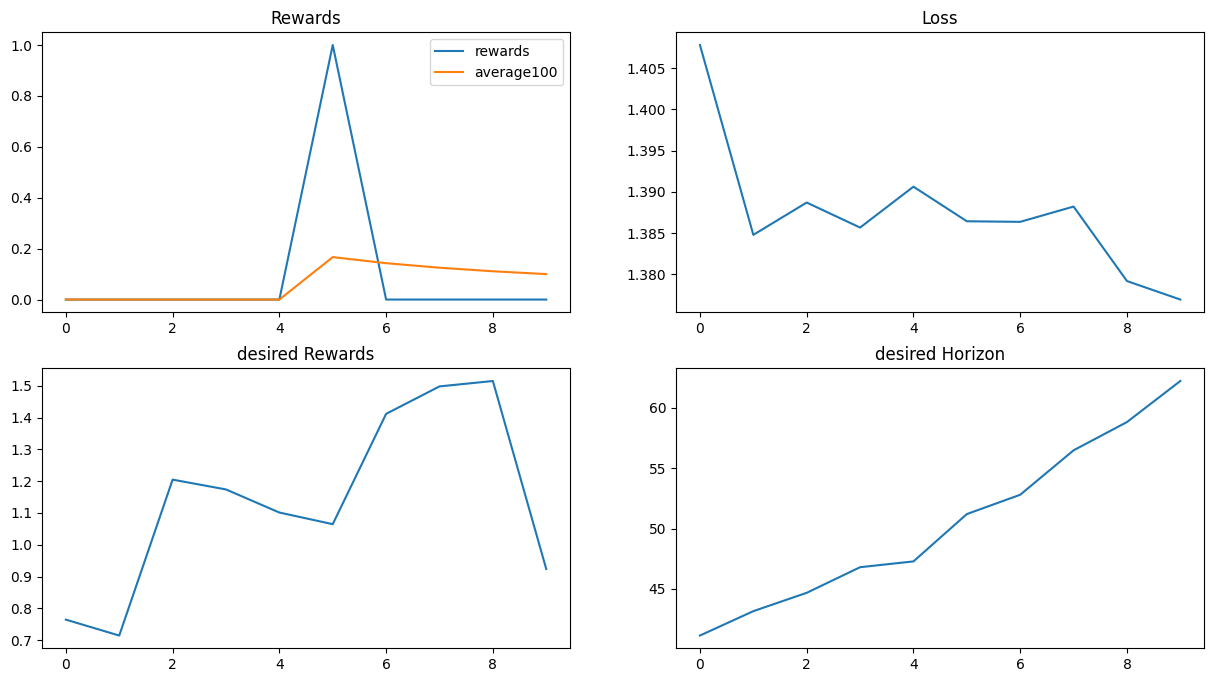

CPU times: total: 2min 37s
Wall time: 27.9 s


In [23]:
%%time
rewards, average, d, h, loss = run_upside_down(max_episodes=10)
t = time.localtime()
current_time = time.strftime("%Hh%Mm%Ss", t)
save_name = "PlotsProducedAt" + current_time + ".png"
save_name_bf = "BFProducedAt" + current_time + ".pth"
torch.save(bf.state_dict(), save_name_bf)
plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
plt.title("Rewards")
plt.plot(rewards, label="rewards")
plt.plot(average, label="average100")
plt.legend()
plt.subplot(2,2,2)
plt.title("Loss")
plt.plot(loss)
plt.subplot(2,2,3)
plt.title("desired Rewards")
plt.plot(d)
plt.subplot(2,2,4)
plt.title("desired Horizon")
plt.plot(h)
plt.savefig(save_name)
plt.show()

In [24]:
# SAVE MODEL
name = "ModelProducedAt" + current_time + ".pth"
torch.save(bf.state_dict(), name)
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

Execution time in seconds: 33.07957148551941


In [25]:
## OBSERVE THE WEIGHTS after training
#for p in bf.parameters():
#    print(p)

## EVALUATION RUN

In [26]:
# DESIRED_REWARD = torch.FloatTensor([200]).to(device)
# DESIRED_HORIZON = torch.FloatTensor([200]).to(device)
# desired = DESIRED_REWARD.item()
#
# env = gym.make('CartPole-v0')
# env.reset()
# rewards = 0
# while True:
#     command = torch.cat((DESIRED_REWARD*return_scale,DESIRED_HORIZON*horizon_scale), dim=-1)
#
#     probs_logits = bf(torch.from_numpy(state).float().to(device), command)
#     probs = torch.softmax(probs_logits, dim=-1).detach().cpu()
#     action = torch.argmax(probs).item()
#     state, reward, done, info = env.step(action)
#     rewards += reward
#     DESIRED_REWARD -= reward
#     DESIRED_HORIZON -= 1
#     if done:
#         break
#
# print("Desired rewards: {} | after finishing one episode the agent received {} rewards".format(desired, rewards))
env.close()